In [ ]:
 pip install QuantLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 70.8 MB/s eta 0:00:00


# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***LIBRARIES***

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import os
from scipy.stats import norm
from scipy.optimize import minimize
import QuantLib as ql
from datetime import datetime

#torch.manual_seed(123)
np.random.seed(123)

# ***MODEL***

In [ ]:
# Define the ABU activation function for the SABR PDE
class SinSoftplusActivation(nn.Module):
    def forward(self, input):
        new_act_f = 0.005*torch.sin(input) + 1*torch.nn.functional.softplus(input) + 0*torch.nn.functional.tanh(input) + 0.00*torch.nn.functional.gelu(input)
        return new_act_f

In [ ]:
class Alternative_FCN(nn.Module):
    def __init__(self):
        super(Alternative_FCN, self).__init__()
        self.bn1 = nn.BatchNorm1d(3)
        self.fc1 = nn.Linear(3, 200)
        self.act1 = SinSoftplusActivation()
        self.bn2 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.act2 = SinSoftplusActivation()
        self.bn3 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.act3 = SinSoftplusActivation()
        self.bn4 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 200)
        self.act4 = SinSoftplusActivation()
        self.bn5 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200, 200)
        self.act5 = SinSoftplusActivation()
        self.bn6 = nn.BatchNorm1d(200)
        self.fc6 = nn.Linear(200, 1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        return x

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[0.3, 149.7])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.8, 149.5])


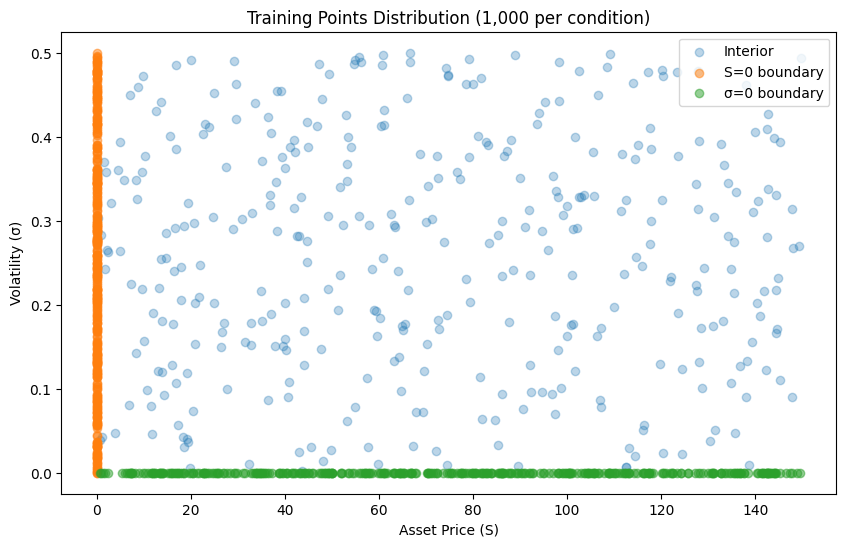

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

# ***PDE AND PINN CONDITIONS***

In [ ]:
# Define a function to compute the partial derivatives needed for the Heston PDE
def compute_derivatives_heston(model, S, v, t):
    inputs = torch.cat([S, v, t], dim=1)
    # Compute C (option price)
    C = model(inputs)

    # Compute partial derivatives using autograd
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_v = torch.autograd.grad(C, v, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    C_vv = torch.autograd.grad(C_v, v, grad_outputs=torch.ones_like(C_v), create_graph=True)[0]
    C_Sv = torch.autograd.grad(C_S, v, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    return C, C_S, C_v, C_t, C_SS, C_Sv, C_vv

    # Define the Heston PDE
def heston_pde(model, S, v, t, kappa, theta, sigma, rho, r):
    C, C_S, C_v, C_t, C_SS, C_Sv, C_vv = compute_derivatives_heston(model, S, v, t)
    rho = torch.tensor(rho, dtype=torch.float32, device=S.device)
    sigma = torch.tensor(sigma, dtype=torch.float32, device=S.device)
    kappa = torch.tensor(kappa, dtype=torch.float32, device=S.device)
    theta = torch.tensor(theta, dtype=torch.float32, device=S.device)
    r = torch.tensor(r, dtype=torch.float32, device=S.device)
    # Compute the terms of the Heston PDE
    term1 = C_t
    term2 = 0.5 * v * S**2 * C_SS
    term3 = rho * sigma * v * S * C_Sv
    term4 = 0.5 * sigma**2 * v * C_vv
    term5 = r * S * C_S
    term6 = kappa * (theta - v) * C_v
    term7 = -r * C

    # Heston PDE that equals zero
    residual = term1 + term2 + term3 + term4 + term5 + term6 + term7
    return residual

# Define boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min)  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

# Define boundary conditions
def Smax_conditions2(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    dVdS = V_S_max_dx[:, 0].reshape(-1, 1)
    boundary_S_max = dVdS - 1
    boundary_S_max = torch.mean(boundary_S_max**2)
    return boundary_S_max

    # Define boundary conditions
def Smax_conditions(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    V_S_max_d2x = torch.autograd.grad(V_S_max_dx, inputs_S_max, torch.ones_like(V_S_max_dx), create_graph=True)[0]
    dSmaxd2x = V_S_max_d2x[:, 0].reshape(-1, 1)
    boundary_S_max = torch.mean(dSmaxd2x**2)
    return boundary_S_max

# Define boundary conditions
def v0_conditions(model, inputs_v_min, K, r):
    # Boundary condition for alpha = 0
    Vmin_S = inputs_v_min[:, 0].reshape(-1, 1)
    Vmin_t = inputs_v_min[:, 2].reshape(-1, 1)
    V_v_min = model(inputs_v_min)
    V_v_min_dt = torch.autograd.grad(V_v_min, inputs_v_min, torch.ones_like(V_v_min), create_graph=True)[0]
    dVmindt = V_v_min_dt[:, 2].reshape(-1, 1)
    #boundary_alpha_min = V_alpha_min_dt
    boundary_v_min = V_v_min - torch.maximum(Vmin_S - K*torch.exp(-r*Vmin_t), torch.tensor(0.0))
    boundary_v_min = torch.mean(boundary_v_min**2)

    return boundary_v_min
# Define boundary conditions
def Vmax_conditions(model, inputs_v_max):
    # Boundary condition for alpha = 0
    Vmax_S = inputs_v_max[:, 0].reshape(-1, 1)
    V_v_max = model(inputs_v_max)
    boundary_v_max = V_v_max - Vmax_S
    boundary_v_max = torch.mean(boundary_v_max**2)

    return boundary_v_max


def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0))
    return val.view(-1, 1).requires_grad_(True)

def ame_condition(model, inputs_ame, K):
    fS = inputs_ame[:, 0].requires_grad_(True).reshape(-1, 1)

    C = model(inputs)
    exercise_value = torch.maximum(fS - K, torch.tensor(0.0))
    bnd_ame_early = torch.mean(torch.relu(exercise_value - C)**2)  # Penalty if C < intrinsic value

    return bnd_ame_early

# ***CALIBRATION***

In [ ]:
# Heston model calibration function
def heston_calibration_error(params, market_prices, strike_prices, maturities, spots, risk_free_rate=0.0007, dividend_rate=0.0):
    """
    Calculate the squared errors between market and Heston model prices.

    params: [v0, kappa, theta, sigma, rho]
    """
    v0, kappa, theta, sigma, rho = params

    # Set up QuantLib calendar and day counter
    calendar = ql.NullCalendar()
    day_count = ql.Actual365Fixed()

    calculation_date = ql.Date().from_date(datetime.now().date())
    ql.Settings.instance().evaluationDate = calculation_date

    errors = []

    for i, (K, T, market_price, spot) in enumerate(zip(strike_prices, maturities, market_prices, spots)):
        # Skip if maturity is zero or negative
        if T <= 0:
            continue

        # Create option payoff and exercise
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, float(K))
        exercise = ql.EuropeanExercise(calculation_date + ql.Period(int(T*252), ql.Days))

        # Create Heston process
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
        dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

        heston_process = ql.HestonProcess(flat_ts, dividend_ts, spot_handle,
                                         v0, kappa, theta, sigma, rho)

        # Create Heston model and engine
        heston_model = ql.HestonModel(heston_process)
        engine = ql.AnalyticHestonEngine(heston_model)

        # Price the option
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(engine)

        try:
            heston_price = option.NPV()
        except:
            heston_price = 0  # Return 0 if pricing fails

        # Calculate squared error
        error = (heston_price - market_price)**2
        errors.append(error)

    # Return mean squared error
    return np.mean(errors)

In [ ]:
def sabr_volatility(alpha, beta, rho, nu, F, K, T):
    """ Computes the SABR model implied volatility using Hagan's formula """
    if F == K:  # ATM case
        FK_beta = F**(1 - beta)
        vol = alpha / FK_beta * (1 + (((1 - beta) ** 2) / 24 * (alpha**2 / FK_beta**2) +
                                     (1 / 4) * (rho * beta * nu * alpha / FK_beta) +
                                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
    else:
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        FK_beta = (F * K) ** ((1 - beta) / 2)
        term1 = (1 + ((((1-beta)**2)/24)*((alpha**2)/FK_beta**2) +
                     (1 / (4*FK_beta)) * (rho * beta * nu * alpha) +
                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
        term2 = (1 + ((((1 - beta) ** 2) / 24) * ((np.log(F/K)) ** 2)) +
                 ((((1 - beta) ** 4) / 1920) * ((np.log(F/K)) ** 4)))
        vol = (alpha / FK_beta) * (z / x_z) * term1 / term2
    return vol

# Loss function to minimize
def sabr_loss(params, F, strikes, T, market_vols):
    alpha, beta, rho, nu = params
    model_vols = np.array([sabr_volatility(alpha, beta, rho, nu, F, K, T) for K in strikes])
    return np.sum((model_vols - market_vols) ** 2)

# ***ANALYTICAL BS - MONTE CARLO***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# MONTE CARLO OPTION PRICE

def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices


# ***CALLING REAL DATASET***

In [ ]:
# Load all sheets in the Excel file
excel_file = "/content/drive/MyDrive/Bitirme_real_dataset/american_options.xlsx"
sheet_names = pd.ExcelFile(excel_file).sheet_names

results_MC_df = pd.DataFrame(columns=["Sheet", "Heston Model MSE", "Heston Model MAPE"])

prediction_df = pd.DataFrame()

output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/ame"
os.makedirs(output_dir, exist_ok=True)

# ***TRAINING***

In [ ]:
for sheet_name in sheet_names:
    print(f"Processing sheet: {sheet_name}")
    # Load data for the current sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    F = df['close'].values  # SPOT PRICE
    spot_price = df['close'].iloc[0]
    sigma = df['implied_volatility'].values
    K = df['strike'].values
    market_prices = df['Option_mid'].values
    time = df['Remaining_day'].values / 252

    df_no_zeros = df[df["Option_mid"] != 0]

    F_nozero = df['close'].values  # SPOT PRICE
    spot_price_nozero = df['close'].iloc[0]
    sigma_nozero = df['implied_volatility'].values
    K_nozero = df['strike'].values
    market_prices_nozero = df['Option_mid'].values
    time_nozero = df['Remaining_day'].values / 252

    print( "F: ", F)
    print( "F no zero: ", F_nozero)
    print( "spot price no zero: ", spot_price_nozero)

    # Initial parameter guesses for heston
    initial_params_heston = [sigma_nozero[0]**2, 2.0, 0.04, 0.1, -0.7] # v0 - initial variance, kappa - mean reversion speed, theta - long-term variance, sigma - vol of vol, rho - correlation

     # Bounds for heston parameters (v0 > 0, kappa > 0, theta > 0, sigma > 0, -1 <= rho <= 1)
    bounds_heston = [(0.01, 0.5), (0.1, 10.0), (0.01, 0.5), (0.01, 1.0), (-0.99, 0.99)]

    # Run calibration for heston parameters
    result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),
                                        bounds=bounds_heston, method='L-BFGS-B', options={'maxiter': 100, 'disp': True})

    # Extract calibrated heston parameters
    v0_heston, kappa, theta, sigma_heston, rho_heston = result_parameters_heston.x

    print("Optimized Heston parameters:")
    print("v0:", v0_heston)
    print("kappa:", kappa)
    print("theta:", theta)
    print("sigma_heston:", sigma_heston)
    print("rho_heston:", rho_heston)

    # Initial guess for SABR parameters
    initial_guess = [sigma[0], 1, 0.0, 0.3]

        # Optimize SABR parameters
    result_parameters = minimize(sabr_loss, initial_guess, args=(F[0], K, time[0], sigma),
                              bounds=[(0.01, 1), (0, 1), (-0.99, 0.99), (0.01, None)])

    alfa, beta, rho, nu = result_parameters.x

    print("Optimized SABR parameters:")
    print("Alpha:", alfa)
    print("Beta:", beta)
    print("Rho:", rho)
    print("Nu:", nu)

        # Veriyi torch tensöre dönüştür
    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

    # min max değerler
    F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
    v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

    r=0.0007

    lambda1, lambda2 = 1, 1

    model = Alternative_FCN()
    optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=200,
        min_lr=2e-5)

    best_loss = float('inf')
    save_path = 'best_model.pth'

    totallosses=[]
    Lic_list = []
    Lpde_list = []
    Lbd_list = []
    Lbd_Smax_list = []
    Lbd_Smin_list = []
    Lbd_Vmax_list = []
    Lbd_V0_list = []

# Compute model

    for i in range(1000):
        data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

        t0 = data['initial'].clone().detach().requires_grad_(True)
        V0 = data['bd_sigma0'].clone().detach().requires_grad_(True)
        S0 = data['bd_S0'].clone().detach().requires_grad_(True)
        Smax = data['bd_Smax'].clone().detach().requires_grad_(True)
        vmax = data['bd_sigmamax'].clone().detach().requires_grad_(True)
        inputs = data['interior'].clone().detach().requires_grad_(True)
        inputs_all = data['all'].clone().detach().requires_grad_(True)


        C0 = model(t0)
        loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1), K[0]))**2
        Lic = lambda1 * loss1.mean()

    # Compute the PDE residual as the loss
        residual = heston_pde(model, inputs[:,0].requires_grad_(True).reshape(-1, 1), inputs[:,1].requires_grad_(True).reshape(-1, 1), inputs[:,2].requires_grad_(True).reshape(-1, 1),  kappa, theta, sigma_heston, rho_heston, r)
        Lpde = lambda2 *torch.mean(torch.relu(-residual)**2)  #AMERICAN OPTION (C-max(S-K, 0)) >= 0 , pde >= 0

        bnd_early = ame_condition(model, inputs, K[0])

        bnd_S_min = Smin_conditions(model, S0)

        bnd_S_max = Smax_conditions(model, Smax)

        bnd_v_min = v0_conditions(model, V0, K[0], r)

        bnd_v_max = Vmax_conditions(model, vmax)

        Lbd = ( 10*bnd_S_max + 0.0001*bnd_v_max + 1000000*bnd_v_min + 1*bnd_S_min )
        Lic2 = 0.0000015*Lic
        Lpde2 = Lpde
        loss = Lic2 + Lpde2 + Lbd

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

        totallosses.append(loss.item())
        Lic_list.append(Lic2.item())
        Lpde_list.append(Lpde2.item())
        Lbd_list.append(Lbd.item())

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
            print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
            print("CURRENT LR:", scheduler.get_last_lr())

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'iteration': i
                }, save_path)

    print("best loss: ", best_loss )

    checkpoint = torch.load("best_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
    time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)

    inputs_heston = torch.cat([F_torch, sigma_torch, time_torch], dim=1)

    C = model(inputs_heston) # PINN OPTION PRICES
    C = C.detach().numpy()

    bs_op_pr = black_scholes_option_price(F, K[0], time, r, sigma) # ANALYTICAL BS OPTION PRICES

    mc = sabr_european_call_mc(F, sigma, time, K[0], r, beta2, nu2, rho2, N=100, M=10000, confidence=0.95) # MONTE CARLO OPTIONS PRİCES

    plt.plot(time, C, label="Heston-PINN", linestyle='dashed')
    plt.plot(time, bs_op_pr, label="Analytical BS Values")
    plt.plot(time, mc, label="Monte Carlo Values")
    plt.xlabel("Time (t)")
    plt.ylabel("Option Price (C)")
    plt.legend()
    plot_path = os.path.join(output_dir, f"{sheet_name}_option_price_plot_time.png")
    plt.savefig(plot_path)
    plt.close()
    plt.show()

    mse1 = np.mean((mc - C.ravel())**2)
    mape1 = np.mean(np.abs((mc - C.ravel()) / mc))
    print("MSE between MC and PINN:", mse1)
    print("MAPE between MC and PINN::", mape1)

    new_row = pd.DataFrame({
    "Sheet": [sheet_name],
    "Heston Model MSE": [mse1],
    "Heston Model MAPE": [mape1],
    })

    results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)

    prediction_df[f'Heston_{sheet_name}'] = pd.Series(C.flatten())



Processing sheet: A
F:  [41.879999 42.029999 42.86     42.550001 42.209999 43.349999 43.67
 43.430001 43.539999 43.239999 43.05     43.869999 44.15     44.639999
 44.3      44.66     45.290003 45.18     44.639999 44.4      44.780002
 45.290003 44.26     45.000002 45.090001 45.010002 45.080002 44.599999
 44.62     44.749999 44.580001 42.249999 43.01     42.24     41.630001
 41.8      41.289999 40.970001 41.729999 41.479999 41.930001 42.029999
 42.660001 43.239999 43.250001 43.030001 42.810001 42.619999 43.000001
 43.320001 43.01     42.550001 42.000001 42.700001 41.65     41.249999
 41.13     41.820001 42.09     41.970001 40.930001 40.66     40.519999
 41.410001 41.54     41.659999 41.65     42.260001 43.86     44.749999
 43.04     43.389999 42.190001 41.83     42.000001 41.850001 42.609999
 42.850001 42.729999 41.300001 41.46     41.439999 41.31     41.479999
 41.549999 42.000001 42.400001 42.94     43.16     43.63     43.04
 43.97     45.680001 44.989998 45.559999]
F no zero:  [41.879

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.16360435160627904
kappa: 2.000000277555758
theta: 0.03999582070420238
sigma_heston: 0.09999470701172732
rho_heston: -0.6999993664789897
Optimized SABR parameters:
Alpha: 0.39532095046376325
Beta: 0.976724798751423
Rho: 0.018544715903049656
Nu: 0.2932543331343732


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Iteration 0, Loss: 300117664.0
Loss-1 (IC): 0.0004136861825827509, Loss-2 (pde): 8.281475061266974e-09 , Loss-5 (bd): 300117664.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 1175208.875
Loss-1 (IC): 0.00046318292152136564, Loss-2 (pde): 0.15663237869739532 , Loss-5 (bd): 1175208.75
CURRENT LR: [0.0002]
Iteration 200, Loss: 234627.5
Loss-1 (IC): 0.00044706015614792705, Loss-2 (pde): 0.1441294252872467 , Loss-5 (bd): 234627.359375
CURRENT LR: [0.0002]
Iteration 300, Loss: 99829.9765625
Loss-1 (IC): 0.0004593922640196979, Loss-2 (pde): 0.4998153746128082 , Loss-5 (bd): 99829.4765625
CURRENT LR: [0.0002]
Iteration 400, Loss: 71140.34375
Loss-1 (IC): 0.00043194476165808737, Loss-2 (pde): 1.0024592876434326 , Loss-5 (bd): 71139.34375
CURRENT LR: [0.0002]
Iteration 500, Loss: 55938.93359375
Loss-1 (IC): 0.0004582187393680215, Loss-2 (pde): 0.78183513879776 , Loss-5 (bd): 55938.15234375
CURRENT LR: [0.0002]
Iteration 600, Loss: 47543.28515625
Loss-1 (IC): 0.00045104132732376456, Loss-2 (pde): 0.

/tmp/ipython-input-2940639486.py:210: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)


F:  [549.029976 542.099991 526.999992 523.900002 525.31002  517.100006
 523.509979 520.300026 501.750015 485.920013 506.089981 502.680023
 500.000015 504.770004 514.010002 450.499977 439.880001 449.830002
 458.269981 456.830002 455.489998 453.619995 442.320004 457.840012
 457.350014 468.220009 474.980003 479.930023 467.900002 467.009995
 466.590012 460.160011 459.990021 448.850006 446.060009 450.809998
 442.799988 448.970009 444.569988 441.400009 430.470013 420.049988
 431.139988 425.659996 430.580002 431.720001 437.869995 428.429993
 428.349991 432.499992 443.660007 455.720016 454.489975 452.079987
 452.729988 461.910011 463.580009 461.140007 452.079987 442.660011
 428.910004 429.789997 431.989994 427.71999  423.199993 426.209995
 426.98     435.689999 434.329994 429.800011 419.85001  426.240009
 402.800007 392.049988 390.530006]
F no zero:  [549.029976 542.099991 526.999992 523.900002 525.31002  517.100006
 523.509979 520.300026 501.750015 485.920013 506.089981 502.680023
 500.000015

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.5
kappa: 10.0
theta: 0.01
sigma_heston: 0.5761802045485922
rho_heston: -0.99
Optimized SABR parameters:
Alpha: 0.4217032239383481
Beta: 0.9683485937138233
Rho: 0.031230566746666445
Nu: 0.2909128438363357
Iteration 0, Loss: 30641616896.0
Loss-1 (IC): 0.04592599347233772, Loss-2 (pde): 0.025565151125192642 , Loss-5 (bd): 30641616896.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 3768338432.0
Loss-1 (IC): 0.039231106638908386, Loss-2 (pde): 117.86911010742188 , Loss-5 (bd): 3768338432.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 3107800832.0
Loss-1 (IC): 0.0389573834836483, Loss-2 (pde): 2520.611328125 , Loss-5 (bd): 3107798272.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 408998464.0
Loss-1 (IC): 0.04661428928375244, Loss-2 (pde): 69108.875 , Loss-5 (bd): 408929344.0
CURRENT LR: [0.0002]
Iteration 400, Loss: 2939801088.0
Loss-1 (IC): 0.04054240509867668, Loss-2 (pde): 5943.916015625 , Loss-5 (bd): 2939795200.0
CURRENT LR: [0.0002]
Iteration 500, Loss: 8566808

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.06599761000000001
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.2559198670890043
Beta: 0.9965087085050515
Rho: 0.00023012659784105396
Nu: 0.29953536404470277
Iteration 0, Loss: 114030362624.0
Loss-1 (IC): 0.16588194668293, Loss-2 (pde): 0.6047740578651428 , Loss-5 (bd): 114030362624.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 8497156096.0
Loss-1 (IC): 0.12190805375576019, Loss-2 (pde): 1017.6044921875 , Loss-5 (bd): 8497155072.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 6496185856.0
Loss-1 (IC): 0.12314710766077042, Loss-2 (pde): 54900.7421875 , Loss-5 (bd): 6496131072.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 6102917120.0
Loss-1 (IC): 0.14475828409194946, Loss-2 (pde): 41958.78125 , Loss-5 (bd): 6102875136.0
CURRENT LR: [0.0002]
Iteration 400, Loss: 7530925568.0
Loss-1 (IC): 0.1217990443110466, Loss-2 (pde): 16450.4140625 , Loss-5 (bd): 7530909184.0
CURRENT LR: [0.0002]
Iteration 500, Loss: 4437300224

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.21141604
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.4572532137072797
Beta: 0.9943379138417455
Rho: 0.000757355951041313
Nu: 0.2987809630741417
Iteration 0, Loss: 231117456.0
Loss-1 (IC): 0.0003708464209921658, Loss-2 (pde): 1.5025968025383918e-08 , Loss-5 (bd): 231117456.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 964376.9375
Loss-1 (IC): 0.00026311445981264114, Loss-2 (pde): 0.02697516232728958 , Loss-5 (bd): 964376.9375
CURRENT LR: [0.0002]
Iteration 200, Loss: 137589.1875
Loss-1 (IC): 0.00029264192562550306, Loss-2 (pde): 0.25580736994743347 , Loss-5 (bd): 137588.9375
CURRENT LR: [0.0002]
Iteration 300, Loss: 90271.3203125
Loss-1 (IC): 0.00028982263756915927, Loss-2 (pde): 0.3319534957408905 , Loss-5 (bd): 90270.984375
CURRENT LR: [0.0002]
Iteration 400, Loss: 56679.8828125
Loss-1 (IC): 0.0002976930409204215, Loss-2 (pde): 0.33671364188194275 , Loss-5 (bd): 56679.546875
CURRENT LR: [0.0002]
Iterati

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.05793649
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.2650423833536799
Beta: 0.9999999184428523
Rho: -0.010103722098842765
Nu: 0.3182044562526008
Iteration 0, Loss: 800256000.0
Loss-1 (IC): 0.0013073714217171073, Loss-2 (pde): 5.235889693722129e-05 , Loss-5 (bd): 800256000.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 16548189.0
Loss-1 (IC): 0.0013675063382834196, Loss-2 (pde): 4.407342433929443 , Loss-5 (bd): 16548185.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 482430.375
Loss-1 (IC): 0.0013454653089866042, Loss-2 (pde): 4.9114251136779785 , Loss-5 (bd): 482425.46875
CURRENT LR: [0.0002]
Iteration 300, Loss: 161109.125
Loss-1 (IC): 0.0012835306115448475, Loss-2 (pde): 8.099528312683105 , Loss-5 (bd): 161101.03125
CURRENT LR: [0.0002]
Iteration 400, Loss: 158258.796875
Loss-1 (IC): 0.001399379805661738, Loss-2 (pde): 30.770551681518555 , Loss-5 (bd): 158228.03125
CURRENT LR: [0.0002]
Iteration 500, Loss: 

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.038769609999999996
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.3122491394703859
Beta: 0.9999846854074492
Rho: -0.1432537072230218
Nu: 0.6492500528920278
Iteration 0, Loss: 454323840.0
Loss-1 (IC): 0.0007003931095823646, Loss-2 (pde): 5.9263849834678695e-05 , Loss-5 (bd): 454323840.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 8556647.0
Loss-1 (IC): 0.0008485243888571858, Loss-2 (pde): 20.71780014038086 , Loss-5 (bd): 8556626.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 285168.8125
Loss-1 (IC): 0.0008934293873608112, Loss-2 (pde): 25.28308868408203 , Loss-5 (bd): 285143.53125
CURRENT LR: [0.0002]
Iteration 300, Loss: 137082.640625
Loss-1 (IC): 0.0008536080713383853, Loss-2 (pde): 30.245420455932617 , Loss-5 (bd): 137052.390625
CURRENT LR: [0.0002]
Iteration 400, Loss: 109743.0859375
Loss-1 (IC): 0.0008694232674315572, Loss-2 (pde): 35.22802734375 , Loss-5 (bd): 109707.859375
CURRENT LR: [0.0002]
Iteration 

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.061404839999999995
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.3161462654563922
Beta: 0.9999871313846183
Rho: -0.0908259803559365
Nu: 0.45643364747103166
Iteration 0, Loss: 97010632.0
Loss-1 (IC): 0.000143377561471425, Loss-2 (pde): 1.5496176274609752e-05 , Loss-5 (bd): 97010632.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 991420.8125
Loss-1 (IC): 0.00014792298316024244, Loss-2 (pde): 0.11521277576684952 , Loss-5 (bd): 991420.6875
CURRENT LR: [0.0002]
Iteration 200, Loss: 182831.828125
Loss-1 (IC): 0.00015507593343500048, Loss-2 (pde): 0.15539497137069702 , Loss-5 (bd): 182831.671875
CURRENT LR: [0.0002]
Iteration 300, Loss: 75028.1640625
Loss-1 (IC): 0.00015023630112409592, Loss-2 (pde): 0.46861425042152405 , Loss-5 (bd): 75027.6953125
CURRENT LR: [0.0002]
Iteration 400, Loss: 38097.65234375
Loss-1 (IC): 0.0001459482591599226, Loss-2 (pde): 0.8103513121604919 , Loss-5 (bd): 38096.84375
CURRENT LR: [0.0

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.03437316000000001
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.24454514042587946
Beta: 0.9999964148561682
Rho: -0.04222786803734035
Nu: 0.3973061629948772
Iteration 0, Loss: 1296311680.0
Loss-1 (IC): 0.002093588700518012, Loss-2 (pde): 0.0019911625422537327 , Loss-5 (bd): 1296311680.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 30625426.0
Loss-1 (IC): 0.0021889416966587305, Loss-2 (pde): 42.854068756103516 , Loss-5 (bd): 30625384.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 298813.3125
Loss-1 (IC): 0.0020575460512191057, Loss-2 (pde): 38.70063018798828 , Loss-5 (bd): 298774.625
CURRENT LR: [0.0002]
Iteration 300, Loss: 338187.6875
Loss-1 (IC): 0.0021567444782704115, Loss-2 (pde): 73.40025329589844 , Loss-5 (bd): 338114.28125
CURRENT LR: [0.0002]
Iteration 400, Loss: 139141.84375
Loss-1 (IC): 0.0020294159185141325, Loss-2 (pde): 104.09184265136719 , Loss-5 (bd): 139037.75
CURRENT LR: [0.0002]
Iteration 500,

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.038025
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.25923496031436066
Beta: 0.9999952855504395
Rho: -0.050280912412456615
Nu: 0.4077337847442367
Iteration 0, Loss: 1543291520.0
Loss-1 (IC): 0.002496897941455245, Loss-2 (pde): 0.00035428424598649144 , Loss-5 (bd): 1543291520.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 64444072.0
Loss-1 (IC): 0.002200628397986293, Loss-2 (pde): 6.646195411682129 , Loss-5 (bd): 64444064.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 436774.9375
Loss-1 (IC): 0.002619554055854678, Loss-2 (pde): 54.85893630981445 , Loss-5 (bd): 436720.0625
CURRENT LR: [0.0002]
Iteration 300, Loss: 307856.0
Loss-1 (IC): 0.0025237579829990864, Loss-2 (pde): 61.3728141784668 , Loss-5 (bd): 307794.625
CURRENT LR: [0.0002]
Iteration 400, Loss: 1218120.875
Loss-1 (IC): 0.0026423439849168062, Loss-2 (pde): 64.58964538574219 , Loss-5 (bd): 1218056.25
CURRENT LR: [0.0002]
Iteration 500, Loss: 257090.1093

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.066564
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.26093073739791905
Beta: 1.0
Rho: -0.000256158630742672
Nu: 0.3004349009684718
Iteration 0, Loss: 5267293184.0
Loss-1 (IC): 0.00698075583204627, Loss-2 (pde): 0.0014843499520793557 , Loss-5 (bd): 5267293184.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 348503840.0
Loss-1 (IC): 0.0070731486193835735, Loss-2 (pde): 39.85143280029297 , Loss-5 (bd): 348503808.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 4344775.0
Loss-1 (IC): 0.008303350768983364, Loss-2 (pde): 2469.3173828125 , Loss-5 (bd): 4342305.5
CURRENT LR: [0.0002]
Iteration 300, Loss: 832878.8125
Loss-1 (IC): 0.008635751903057098, Loss-2 (pde): 1167.769287109375 , Loss-5 (bd): 831711.0625
CURRENT LR: [0.0002]
Iteration 400, Loss: 625750.375
Loss-1 (IC): 0.008678215555846691, Loss-2 (pde): 1091.574951171875 , Loss-5 (bd): 624658.8125
CURRENT LR: [0.0002]
Iteration 500, Loss: 542522.6875
Loss-1 (IC): 0.0

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.034151039999999994
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.2802635802845355
Beta: 0.999982758731577
Rho: -0.11681102648830906
Nu: 0.5445565756918634
Iteration 0, Loss: 701379904.0
Loss-1 (IC): 0.0010135292541235685, Loss-2 (pde): 0.0003022690361831337 , Loss-5 (bd): 701379904.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 24909078.0
Loss-1 (IC): 0.0009998230962082744, Loss-2 (pde): 18.140718460083008 , Loss-5 (bd): 24909060.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 610321.1875
Loss-1 (IC): 0.0010742887388914824, Loss-2 (pde): 12.195502281188965 , Loss-5 (bd): 610309.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 344203.21875
Loss-1 (IC): 0.0011313674040138721, Loss-2 (pde): 9.019447326660156 , Loss-5 (bd): 344194.1875
CURRENT LR: [0.0002]
Iteration 400, Loss: 201543.421875
Loss-1 (IC): 0.0010771079687401652, Loss-2 (pde): 16.719982147216797 , Loss-5 (bd): 201526.703125
CURRENT LR: [0.0002]
Iteration 50

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.011620840000000002
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.1942046591461558
Beta: 0.9999944631049601
Rho: -0.09638379876732651
Nu: 0.7526668841101247
Iteration 0, Loss: 852558208.0
Loss-1 (IC): 0.0013566705165430903, Loss-2 (pde): 1.8527889551478438e-05 , Loss-5 (bd): 852558208.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 38638180.0
Loss-1 (IC): 0.0010770222870633006, Loss-2 (pde): 10.461464881896973 , Loss-5 (bd): 38638168.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 300482.40625
Loss-1 (IC): 0.0012847607722505927, Loss-2 (pde): 5.283923625946045 , Loss-5 (bd): 300477.125
CURRENT LR: [0.0002]
Iteration 300, Loss: 245543.0625
Loss-1 (IC): 0.0012248484417796135, Loss-2 (pde): 7.167771339416504 , Loss-5 (bd): 245535.890625
CURRENT LR: [0.0002]
Iteration 400, Loss: 161297.953125
Loss-1 (IC): 0.0012044465402141213, Loss-2 (pde): 11.57266616821289 , Loss-5 (bd): 161286.375
CURRENT LR: [0.0002]
Iteration 5

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.17796671825509938
kappa: 2.00000044686477
theta: 0.03999357458424606
sigma_heston: 0.09999021824125852
rho_heston: -0.6999988252452679
Optimized SABR parameters:
Alpha: 0.38121901812519027
Beta: 0.8946703025209252
Rho: 0.09944714626081709
Nu: 0.2732813944502615
Iteration 0, Loss: 197571136.0
Loss-1 (IC): 0.00028979594935663044, Loss-2 (pde): 2.1727746570832096e-06 , Loss-5 (bd): 197571136.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 1742080.5
Loss-1 (IC): 0.00028146622935310006, Loss-2 (pde): 0.1888674944639206 , Loss-5 (bd): 1742080.25
CURRENT LR: [0.0002]
Iteration 200, Loss: 207758.078125
Loss-1 (IC): 0.000281198212178424, Loss-2 (pde): 0.23519033193588257 , Loss-5 (bd): 207757.84375
CURRENT LR: [0.0002]
Iteration 300, Loss: 84025.3671875
Loss-1 (IC): 0.00029496426577679813, Loss-2 (pde): 0.8971015810966492 , Loss-5 (bd): 84024.46875
CURRENT LR: [0.0002]
Iteration 400, Loss: 47412.390625
Loss-1 (IC): 0.0002941999409813434, Loss-2 (pde): 0.9151721596

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.018090250000000002
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.19571528779099773
Beta: 0.999996504788061
Rho: -0.0378384783200911
Nu: 0.38174311057566485
Iteration 0, Loss: 86894288.0
Loss-1 (IC): 0.00011875625932589173, Loss-2 (pde): 2.6654421725336164e-11 , Loss-5 (bd): 86894288.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 1198135.875
Loss-1 (IC): 0.00014352098514791578, Loss-2 (pde): 0.1018424853682518 , Loss-5 (bd): 1198135.75
CURRENT LR: [0.0002]
Iteration 200, Loss: 144662.15625
Loss-1 (IC): 0.00014615255349781364, Loss-2 (pde): 0.09801442921161652 , Loss-5 (bd): 144662.0625
CURRENT LR: [0.0002]
Iteration 300, Loss: 62868.53515625
Loss-1 (IC): 0.00014024130359757692, Loss-2 (pde): 0.24635958671569824 , Loss-5 (bd): 62868.2890625
CURRENT LR: [0.0002]
Iteration 400, Loss: 36341.9453125
Loss-1 (IC): 0.00014147166803013533, Loss-2 (pde): 0.28046584129333496 , Loss-5 (bd): 36341.6640625
CURRENT LR: [0.

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.29964676
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.5042151557333191
Beta: 0.9151181749460191
Rho: 0.07966238123740094
Nu: 0.28042923319562363
Iteration 0, Loss: 137392432.0
Loss-1 (IC): 0.00020475563360378146, Loss-2 (pde): 3.6230296700523468e-06 , Loss-5 (bd): 137392432.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 883613.5
Loss-1 (IC): 0.00016275593952741474, Loss-2 (pde): 0.08516834676265717 , Loss-5 (bd): 883613.4375
CURRENT LR: [0.0002]
Iteration 200, Loss: 74610.9921875
Loss-1 (IC): 0.00017507541633676738, Loss-2 (pde): 0.6720754504203796 , Loss-5 (bd): 74610.3203125
CURRENT LR: [0.0002]
Iteration 300, Loss: 71585.7265625
Loss-1 (IC): 0.00017496423970442265, Loss-2 (pde): 0.6993994116783142 , Loss-5 (bd): 71585.0234375
CURRENT LR: [0.0002]
Iteration 400, Loss: 48420.4375
Loss-1 (IC): 0.00017253194528166205, Loss-2 (pde): 0.5685304999351501 , Loss-5 (bd): 48419.8671875
CURRENT LR: [0.0002]
Iterati

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.11628100000000002
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.3306174481256663
Beta: 0.9685925648183247
Rho: 0.019073781032785148
Nu: 0.2909100897081254
Iteration 0, Loss: 333358496.0
Loss-1 (IC): 0.0004710259672719985, Loss-2 (pde): 3.5608769621831016e-07 , Loss-5 (bd): 333358496.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 3849842.75
Loss-1 (IC): 0.00045398209476843476, Loss-2 (pde): 1.1911183595657349 , Loss-5 (bd): 3849841.5
CURRENT LR: [0.0002]
Iteration 200, Loss: 172448.40625
Loss-1 (IC): 0.0004992252797819674, Loss-2 (pde): 0.6612333655357361 , Loss-5 (bd): 172447.75
CURRENT LR: [0.0002]
Iteration 300, Loss: 99133.2421875
Loss-1 (IC): 0.0005241367034614086, Loss-2 (pde): 1.3734467029571533 , Loss-5 (bd): 99131.8671875
CURRENT LR: [0.0002]
Iteration 400, Loss: 63317.37890625
Loss-1 (IC): 0.0004914437304250896, Loss-2 (pde): 2.0567917823791504 , Loss-5 (bd): 63315.3203125
CURRENT LR: [0.0002]
Iter

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.094249
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.2980571362894511
Beta: 0.9698606772737499
Rho: 0.011028082832469368
Nu: 0.29127663046781394
Iteration 0, Loss: 180839024.0
Loss-1 (IC): 0.0002558929845690727, Loss-2 (pde): 1.1036378282369697e-06 , Loss-5 (bd): 180839024.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 1109063.0
Loss-1 (IC): 0.000268817413598299, Loss-2 (pde): 0.1534780114889145 , Loss-5 (bd): 1109062.875
CURRENT LR: [0.0002]
Iteration 200, Loss: 195938.59375
Loss-1 (IC): 0.0002699964097701013, Loss-2 (pde): 0.16530506312847137 , Loss-5 (bd): 195938.421875
CURRENT LR: [0.0002]
Iteration 300, Loss: 89589.046875
Loss-1 (IC): 0.0002719653712119907, Loss-2 (pde): 0.856460690498352 , Loss-5 (bd): 89588.1875
CURRENT LR: [0.0002]
Iteration 400, Loss: 48482.55859375
Loss-1 (IC): 0.000274637364782393, Loss-2 (pde): 1.9083247184753418 , Loss-5 (bd): 48480.6484375
CURRENT LR: [0.0002]
Iteration 500, L

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.0576
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.282021033968996
Beta: 0.9999975860277672
Rho: -0.03762428324550569
Nu: 0.3714000430010855
Iteration 0, Loss: 192128912.0
Loss-1 (IC): 0.00028381485026329756, Loss-2 (pde): 4.0051682503872144e-07 , Loss-5 (bd): 192128912.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 1295991.875
Loss-1 (IC): 0.0002786501427181065, Loss-2 (pde): 0.7567092180252075 , Loss-5 (bd): 1295991.125
CURRENT LR: [0.0002]
Iteration 200, Loss: 148281.15625
Loss-1 (IC): 0.00027612262056209147, Loss-2 (pde): 1.7265163660049438 , Loss-5 (bd): 148279.421875
CURRENT LR: [0.0002]
Iteration 300, Loss: 65632.6953125
Loss-1 (IC): 0.0002938958059530705, Loss-2 (pde): 3.6454849243164062 , Loss-5 (bd): 65629.046875
CURRENT LR: [0.0002]
Iteration 400, Loss: 46267.5703125
Loss-1 (IC): 0.00026745549985207617, Loss-2 (pde): 3.5650405883789062 , Loss-5 (bd): 46264.00390625
CURRENT LR: [0.0002]
Iteration 

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.04322241
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.22227943873918005
Beta: 0.9999999848725699
Rho: -0.0019387843837688145
Nu: 0.30376730628781495
Iteration 0, Loss: 884230144.0
Loss-1 (IC): 0.0013370949309319258, Loss-2 (pde): 4.352029918663902e-06 , Loss-5 (bd): 884230144.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 25387322.0
Loss-1 (IC): 0.0013201807159930468, Loss-2 (pde): 0.7046617865562439 , Loss-5 (bd): 25387322.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 257876.0
Loss-1 (IC): 0.0014498181408271194, Loss-2 (pde): 4.343789100646973 , Loss-5 (bd): 257871.65625
CURRENT LR: [0.0002]
Iteration 300, Loss: 303606.03125
Loss-1 (IC): 0.001540357363410294, Loss-2 (pde): 4.581973552703857 , Loss-5 (bd): 303601.4375
CURRENT LR: [0.0002]
Iteration 400, Loss: 1053582.875
Loss-1 (IC): 0.0014929523458704352, Loss-2 (pde): 6.368492603302002 , Loss-5 (bd): 1053576.5
CURRENT LR: [0.0002]
Iteration 500, Loss: 1798

/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.16048036000000002
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.39735129568374344
Beta: 0.9932197227417094
Rho: 0.0015674316750641352
Nu: 0.2975880092459862
Iteration 0, Loss: 36122092.0
Loss-1 (IC): 5.4026226280257106e-05, Loss-2 (pde): 1.6800746379885823e-05 , Loss-5 (bd): 36122092.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 163126.703125
Loss-1 (IC): 4.768585495185107e-05, Loss-2 (pde): 0.0011139406124129891 , Loss-5 (bd): 163126.703125
CURRENT LR: [0.0002]
Iteration 200, Loss: 30549.267578125
Loss-1 (IC): 4.748449646285735e-05, Loss-2 (pde): 0.06699716299772263 , Loss-5 (bd): 30549.201171875
CURRENT LR: [0.0002]
Iteration 300, Loss: 25623.5703125
Loss-1 (IC): 4.797071233042516e-05, Loss-2 (pde): 0.08182568848133087 , Loss-5 (bd): 25623.48828125
CURRENT LR: [0.0002]
Iteration 400, Loss: 19223.91796875
Loss-1 (IC): 4.881566928816028e-05, Loss-2 (pde): 0.09603282809257507 , Loss-5 (bd): 19223.822265625


/tmp/ipython-input-2940639486.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.03006756
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.23610427668431044
Beta: 0.9999903182365623
Rho: -0.0758874702053863
Nu: 0.5335626520991193
Iteration 0, Loss: 392202528.0
Loss-1 (IC): 0.0006475457921624184, Loss-2 (pde): 8.777198672760278e-05 , Loss-5 (bd): 392202528.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 5687350.5
Loss-1 (IC): 0.0005283034988678992, Loss-2 (pde): 1.0548624992370605 , Loss-5 (bd): 5687349.5
CURRENT LR: [0.0002]
Iteration 200, Loss: 263643.1875
Loss-1 (IC): 0.0006167766987346113, Loss-2 (pde): 1.6262776851654053 , Loss-5 (bd): 263641.5625
CURRENT LR: [0.0002]
Iteration 300, Loss: 99686.15625
Loss-1 (IC): 0.0006190154817886651, Loss-2 (pde): 2.7271339893341064 , Loss-5 (bd): 99683.4296875
CURRENT LR: [0.0002]
Iteration 400, Loss: 75616.28125
Loss-1 (IC): 0.0005771387368440628, Loss-2 (pde): 1.986043095588684 , Loss-5 (bd): 75614.296875
CURRENT LR: [0.0002]
Iteration 500, Loss: 6

# ***SAVING***

In [ ]:
# Save results to an Excel file
results_file = "/content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/ame/MSE_MAPE_Results_analytic.xlsx"
results_MC_df.to_excel(results_file, index=False)
print(f"Results saved to {results_file}")


# Save results to an Excel file
results_file2 = "/content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/ame/Predictions.xlsx"
prediction_df.to_excel(results_file2, index=False)
print(f"Results saved to {results_file2}")

Results saved to /content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/ame/MSE_MAPE_Results_analytic.xlsx
Results saved to /content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/ame/Predictions.xlsx
